# 임포트 패키지

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

# 데이터 전처리

In [4]:
import pandas as pd
df_19 = pd.read_csv('/content/drive/MyDrive/팀 프로젝트/2차 프로젝트/df_19_pred.csv')
df_20 = pd.read_csv('/content/drive/MyDrive/팀 프로젝트/2차 프로젝트/df_20_pred.csv')
df_21 = pd.read_csv('/content/drive/MyDrive/팀 프로젝트/2차 프로젝트/df_21_pred.csv')
df = pd.concat([df_19,df_20,df_21])
df.shape

FileNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_increased = pd.read_csv('/content/drive/MyDrive/workspace/cakd5/2차_project/MariaDB 테이블/increased.csv')

In [10]:
df = df_increased

In [43]:
df_temp = df[['SOLDDATE','QUANT']].groupby('SOLDDATE').sum()
df_temp.shape
df_temp

,QUANT
SOLDDATE,
2019-01-01,239000.0
2019-01-02,375000.0
2019-01-03,168000.0
2019-01-04,324000.0
2019-01-05,302000.0
...,...
2021-12-27,294000.0
2021-12-28,351000.0
2021-12-29,276000.0


In [12]:
df_1 = df.loc[df['PRODNAME']=='AE']

In [27]:
df_1['SOLDDATE'] = pd.to_datetime(df_1['SOLDDATE'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df_ae = df_1[['SOLDDATE','QUANT']].groupby(['SOLDDATE']).sum()
df_ae

,QUANT
SOLDDATE,
2019-01-02,27000.0
2019-01-03,17000.0
2019-01-08,14000.0
2019-01-09,10000.0
2019-01-10,9000.0
...,...
2021-12-20,8000.0
2021-12-22,4000.0
2021-12-23,6000.0


In [ ]:
b = np.random.choice(list(df_temp.index), 50)

Text(0.5, 1.0, 'QUANT')

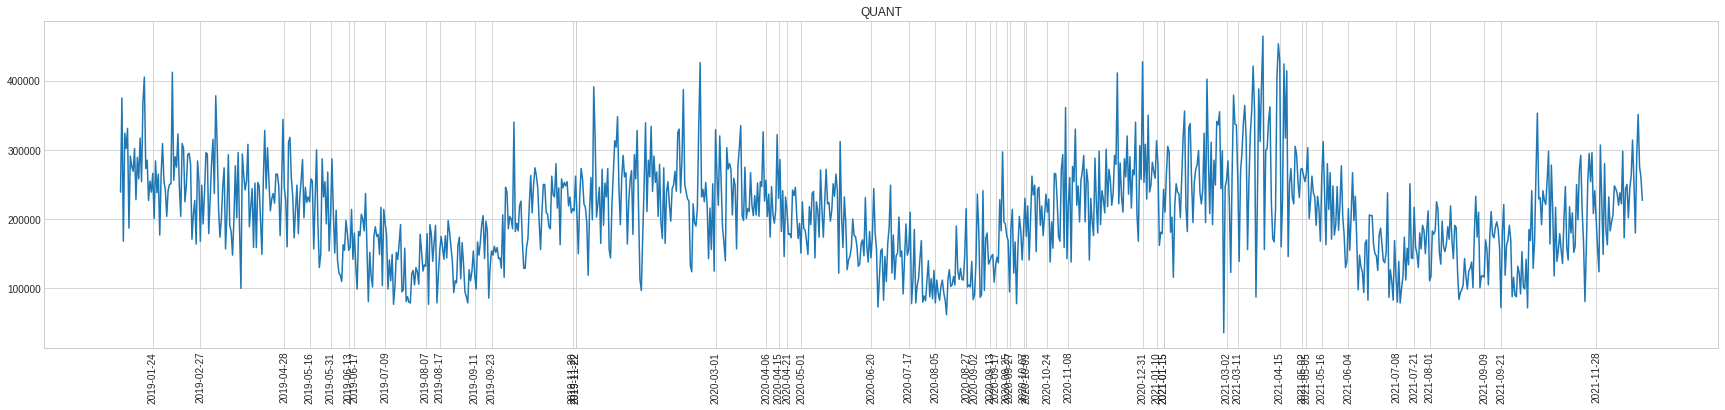

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,6))
plt.style.use(['seaborn-whitegrid'])
plt.plot(list(df_temp.index), df_temp['QUANT'])
plt.xticks(b, rotation = 90)
plt.title('QUANT')

Text(0.5, 1.0, 'AE rolling window=10')

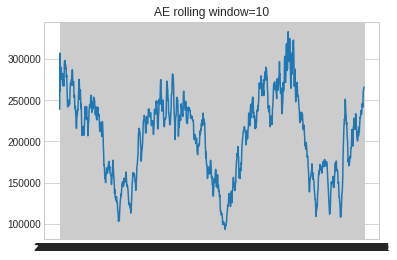

In [ ]:
rolling_10 = df_temp['QUANT'].rolling(10, min_periods=0).mean()
plt.plot(rolling_10)
plt.title(rolling window=10')

In [ ]:
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        series = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array.reshape(-1,1))
    else:
        scaler = None

    return training_data, scaler

In [ ]:
training_data, scaler = preprocess(df_temp['QUANT'], window_size=10)

In [ ]:
training_data, scaler = preprocess(df_temp['QUANT'])

In [ ]:
def make_dataset(training_data, t, h=0, test_size=0.2):
    
    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [ ]:
X_train,X_test,y_train,y_test = make_dataset(df_temp, t = 700)

KeyError: ignored

# MAE, MSE, RMSE 평가지표 함수

In [ ]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

# GRU-adaboost FIT

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
final_model.fit(X_train,y_train)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


11/11 [==============================] - 2s 30ms/step - loss: 0.1223
Epoch 2/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0263
Epoch 3/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0168
Epoch 4/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0112
Epoch 5/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0102
Epoch 6/20
11/11 [==============================] - 0s 29ms/step - loss: 0.0084
Epoch 7/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0063
Epoch 8/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 9/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0066
Epoch 10/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0066
Epoch 11/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0058
Epoch 12/20
11/11 [==============================] - 0s 28ms/step - loss: 0.0056
Epoch 13/20
11/11 [=============================

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f2df09d5fd0>,
                  n_estimators=5, random_state=42)

In [ ]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df_temp['QUANT'][:-len(preds)], preds.squeeze(1)])

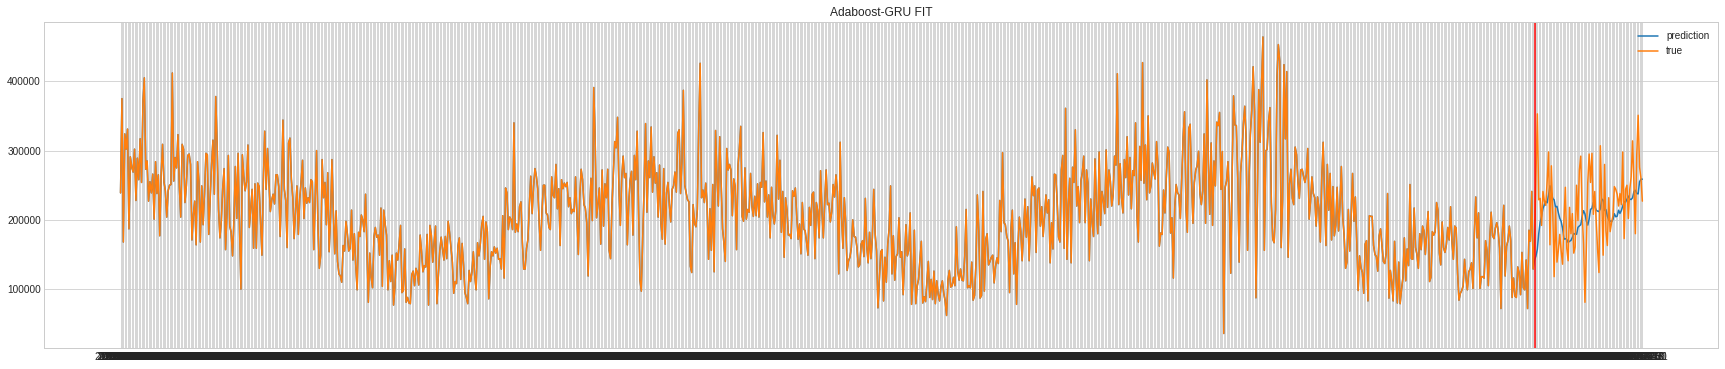

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(preds_series, label='prediction')
plt.plot(df_temp['QUANT'], label='true')
plt.axvline(x=len(df_temp['QUANT'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-GRU FIT')
plt.show()

In [ ]:
y_true = df_temp['QUANT'][-len(preds):]
y_pred = preds.squeeze(1)

In [ ]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

3.70e+04
2.39e+09
4.89e+04


In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(LSTM_Predictors, n_estimators=5, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
final_model.fit(X_train,y_train)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5/5 [==============================] - 2s 11ms/step - loss: 0.0711
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0171
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0113
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0108
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0092
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0077
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0074
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 11/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 12/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 13/20
5/5 [==============================] - 0s 10ms/step - loss: 

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f24df4ffed0>,
                  n_estimators=5, random_state=42)

In [ ]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df_temp['QUANT'][:-len(preds)], preds.squeeze(1)])

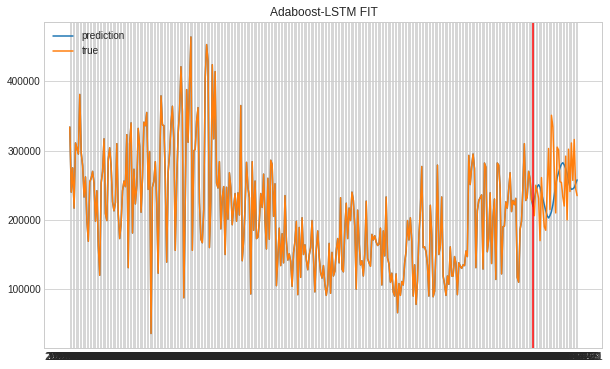

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(preds_series, label='prediction')
plt.plot(df_temp['QUANT'], label='true')
plt.axvline(x=len(df_temp['QUANT'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-LSTM FIT')
plt.show()

In [ ]:
y_true = df_temp['QUANT'][-len(preds):]
y_pred = preds.squeeze(1)

In [ ]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

3.94e+04
2.60e+09
5.10e+04
